<h1 style="text-align: center;"><strong>Prediction of Viral Load Suppression Project</strong></h1>

<p style="text-align: center;"><strong>Degninou Yehadji</strong><br /><span style="color: #0000ff;">TU Dublin, Blanchardstown Campus</span><br /><span style="color: #0000ff;">Dublin 15</span><br /><span style="color: #0000ff;"><em>Email: <a href="mailto:degninou.yehadji@fulbrightmail.org">B00108474@mytudublin.ie</a></em></span> </p>

This is a project conducted using an HIV treatement dataset to predict viral load supression for individuals in the cohort. 

The target variable is Last ART VL Count recoded into a binary variable indicating whether the individual has viral load suppressed or not. The threshold of < 1000 RNA copies/ml is used to define suppressed viral load. 

This Python script is develloped to meet the objective presented above. Specifically, it is intended to: 
- Perform data management tasks on the original dataset 
- Show visualisations of the data using the Python plotting tools
- Develop and evaluate 3 classification models to predict viral load supression 
- Perform cross validation (use k-fold cross validation)
- Perform some searching for optimal values of the hyper or tuning parameters (see GridSearchCV and/or RandomizedSearchCV) in scikit-learn.
- Show the performance of the models by generating classification reports/confusion matrices, ROC curves etc.
- Comment on the process as a whole and in particular on the result of the estimation.

## Import required packages 

In [1]:
# Import required packages 

import os

from sklearn import tree
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from mlxtend.classifier import StackingClassifier
from sklearn.feature_selection import RFE

import pickle
import joblib

from sklearn import svm 
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics 
from sklearn.metrics import RocCurveDisplay
import scikitplot as skplt

import missingno as msno 

import math
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import xlrd

### Set working directory and load dataset

In [2]:
os.chdir ("..\..\MCS Thesis\Modeling")
data_train01 = pd.read_excel('data_train_clean.xlsx')
data_test01 = pd.read_excel('data_test_clean.xlsx')

data_train02 = data_train01.copy()
data_test02 = data_test01.copy()

In [3]:
data_train02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16793 entries, 0 to 16792
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Gender_Male                                16793 non-null  int64
 1   Regiment schedule_3-Month                  16793 non-null  int64
 2   Regiment schedule_6-Month                  16793 non-null  int64
 3   Regiment schedule_Regular                  16793 non-null  int64
 4   Prior ART_Naive                            16793 non-null  int64
 5   Method into ART_New                        16793 non-null  int64
 6   TB Rx Started_Yes                          16793 non-null  int64
 7   TPT Outcome_No treatement                  16793 non-null  int64
 8   TPT Outcome_Other                          16793 non-null  int64
 9   TPT Outcome_Rx completed                   16793 non-null  int64
 10  Regimen At Baseline_1S3E                   167

In [4]:
data_test02.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4054 entries, 0 to 4053
Data columns (total 45 columns):
 #   Column                                     Non-Null Count  Dtype
---  ------                                     --------------  -----
 0   Gender_Male                                4054 non-null   int64
 1   Regiment schedule_3-Month                  4054 non-null   int64
 2   Regiment schedule_6-Month                  4054 non-null   int64
 3   Regiment schedule_Regular                  4054 non-null   int64
 4   Prior ART_Naive                            4054 non-null   int64
 5   Method into ART_New                        4054 non-null   int64
 6   TB Rx Started_Yes                          4054 non-null   int64
 7   TPT Outcome_No treatement                  4054 non-null   int64
 8   TPT Outcome_Other                          4054 non-null   int64
 9   TPT Outcome_Rx completed                   4054 non-null   int64
 10  Regimen At Baseline_1S3E                   4054 

### Create predictors and targets - Training and Test

In [5]:
# Create a subset with potential predictors - Training set
xtrain = data_train02[['Gender_Male',
'Regiment schedule_3-Month',
'Regiment schedule_6-Month',
'Regiment schedule_Regular',
'Prior ART_Naive',
'Method into ART_New',
'TB Rx Started_Yes',
'TPT Outcome_No treatement',
'TPT Outcome_Other',
'TPT Outcome_Rx completed',
'Regimen At Baseline_1S3E',
'Regimen At Baseline_1S3N',
'Regimen At Baseline_1T3E',
'Regimen At Baseline_1T3N',
'Regimen At Baseline_1Z3N',
'Regimen At Baseline_Other',
'Last ART Prescription_1T3E',
'Last ART Prescription_1T3O',
'Last ART Prescription_1Z3N',
'Last ART Prescription_2T3L',
'Last ART Prescription_2Z3L',
'Last ART Prescription_Other',
'Facility_CMC Coléah',
'Facility_CMC Flamboyants',
'Facility_CMC Matam',
'Facility_CMC Minière',
'Facility_CS Dabompa',
'Facility_CS Gbessia port 1',
'Facility_CS Tombolia',
'Facility_CS Wanidara',
'TB Status At Last Visit_No symptoms',
'TB Status At Last Visit_Not Screened',
'TB Status At Last Visit_Other',
'TB Status At Last Visit_Screening Unknown',
'CPT at ART Start_Yes',
'Second Line Rx_Yes',
'Baseline CD4',
'Last Pre-ART CD4',
'Last ART CD4',
'Last Pre-ART Stage',
'Stage at ART Start',
'Age At ART Start',
'Current Age',
'Duration on ART (months)']]

# Create a subset with potential predictors - Test set 
xtest = data_test02[['Gender_Male',
'Regiment schedule_3-Month',
'Regiment schedule_6-Month',
'Regiment schedule_Regular',
'Prior ART_Naive',
'Method into ART_New',
'TB Rx Started_Yes',
'TPT Outcome_No treatement',
'TPT Outcome_Other',
'TPT Outcome_Rx completed',
'Regimen At Baseline_1S3E',
'Regimen At Baseline_1S3N',
'Regimen At Baseline_1T3E',
'Regimen At Baseline_1T3N',
'Regimen At Baseline_1Z3N',
'Regimen At Baseline_Other',
'Last ART Prescription_1T3E',
'Last ART Prescription_1T3O',
'Last ART Prescription_1Z3N',
'Last ART Prescription_2T3L',
'Last ART Prescription_2Z3L',
'Last ART Prescription_Other',
'Facility_CMC Coléah',
'Facility_CMC Flamboyants',
'Facility_CMC Matam',
'Facility_CMC Minière',
'Facility_CS Dabompa',
'Facility_CS Gbessia port 1',
'Facility_CS Tombolia',
'Facility_CS Wanidara',
'TB Status At Last Visit_No symptoms',
'TB Status At Last Visit_Not Screened',
'TB Status At Last Visit_Other',
'TB Status At Last Visit_Screening Unknown',
'CPT at ART Start_Yes',
'Second Line Rx_Yes',
'Baseline CD4',
'Last Pre-ART CD4',
'Last ART CD4',
'Last Pre-ART Stage',
'Stage at ART Start',
'Age At ART Start',
'Current Age',
'Duration on ART (months)']]

# Target -- Training set
ytrain = data_train02[['VL Suppressed_Yes']]
# Target -- Test set
ytest = data_test02[['VL Suppressed_Yes']]

## Support vector machine (SVM)

#### Parameter tunining - Gama

In [6]:
# Create SVM classifer object
SVM_clf = svm.SVC()

parameters = {
    'gamma': ['scale', 'auto']
}

# Create a grid search object
GS_SVM_clf = GridSearchCV(SVM_clf, parameters, n_jobs=-1, cv=3)

# Fit the grid search
GS_SVM_clf.fit(xtrain, ytrain.values.ravel())

# Best paramete set
print('Best parameters found:\n', GS_SVM_clf.best_params_)

Best parameters found:
 {'gamma': 'auto'}


In [7]:
# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(GS_SVM_clf, xtrain, ytrain, cv=3, n_jobs=-1)
print(); print('Accuracy of the 3-fold CVs: ', CV_Result)
print(); print('Mean accuracy: ', CV_Result.mean())
print(); print('Standard deviation: ', CV_Result.std())


Accuracy of the 3-fold CVs:  [0.94158628 0.94551626 0.94229051]

Mean accuracy:  0.9431310164649741

Standard deviation:  0.001710947242051969


#### Parameter tunining - 'C': [5, 10, 20, 30, 40, 50, 60]

In [8]:
# Create SVM classifer object
SVM_clf = svm.SVC(gamma = 'auto')

parameters = {
    'C': [5, 10, 20, 30, 40, 50, 60]
}

# Create a grid search object
GS_SVM_clf = GridSearchCV(SVM_clf, parameters, n_jobs=-1, cv=3)

# Fit the grid search
GS_SVM_clf.fit(xtrain, ytrain.values.ravel())

# Best paramete set
print('Best parameters found:\n', GS_SVM_clf.best_params_)

Best parameters found:
 {'C': 40}


In [9]:
# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(GS_SVM_clf, xtrain, ytrain, cv=3, n_jobs=-1)
print(); print('Accuracy of the 3-fold CVs: ', CV_Result)
print(); print('Mean accuracy: ', CV_Result.mean())
print(); print('Standard deviation: ', CV_Result.std())


Accuracy of the 3-fold CVs:  [0.96891747 0.97302608 0.96748258]

Mean accuracy:  0.9698087104072856

Standard deviation:  0.0023492313135135543


#### Evaluate the model with optimal parameters on test set

In [10]:
# Create SVM classifer object with the optimal parameters
SVM_clf = svm.SVC(C = 40, gamma = 'auto')

# Train the best SVM Classifer
SVM_clf = SVM_clf.fit(xtrain, ytrain.values.ravel())

# Save the model
joblib.dump(SVM_clf, 'SVM_clf.pkl')

#Predict the response for test dataset
target_expected = ytest
target_predicted = SVM_clf.predict(xtest)

# Area Under the Receiver Operating Characteristic Curve (ROC AUC)  
fpr, tpr, thresholds = metrics.roc_curve(target_expected, target_predicted)

# summarize the fit of the model
print('Classification report:\n', metrics.classification_report(target_expected, 
                                                                target_predicted))
print('F1 Score: ', metrics.f1_score(target_expected, target_predicted))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(target_expected, target_predicted))
print('Confusion matrix:\n', metrics.confusion_matrix(target_expected, target_predicted))

Classification report:
               precision    recall  f1-score   support

           0       0.23      0.05      0.08       457
           1       0.89      0.98      0.93      3597

    accuracy                           0.87      4054
   macro avg       0.56      0.51      0.51      4054
weighted avg       0.82      0.87      0.84      4054

F1 Score:  0.9326095591155832
AUC:  0.5147387593235062
Accuracy Score:  0.8744449925999014
Confusion matrix:
 [[  23  434]
 [  75 3522]]


## Random Forest

### Determine max_depth

In [11]:
# Create the parameter grid based on the results of random search 
parameters = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55]
}

# Create a base model
RFR_clf = RandomForestClassifier()

# Instantiate the grid search model
GS_RFR_clf = GridSearchCV(RFR_clf, parameters, cv = 3, n_jobs = -1)

# Fit the grid search to the data
GS_RFR_clf.fit(xtrain, ytrain.values.ravel())

# Best paramete set
print('Best parameters found:\n', GS_RFR_clf.best_params_)

Best parameters found:
 {'max_depth': 25}


In [12]:
# Use Cross Validation To Evaluate Model
CV_Result = cross_val_score(GS_RFR_clf, xtrain, ytrain, cv=3, n_jobs=-1)
print(); print('Accuracy of the 3-fold CVs: ', CV_Result)
print(); print('Mean accuracy: ', CV_Result.mean())
print(); print('Standard deviation: ', CV_Result.std())


Accuracy of the 3-fold CVs:  [0.96570204 0.96588067 0.9619439 ]

Mean accuracy:  0.9645088688757006

Standard deviation:  0.0018151735163316747


### Evaluate the model with optimal parameters on test set

In [13]:
# Create RF classifer object with the optimal parameters
RFR_clf = RandomForestClassifier(max_depth = 40)

# Train the best RF Classifer
RFR_clf = RFR_clf.fit(xtrain, ytrain.values.ravel())

# Save the model
joblib.dump(RFR_clf, 'RDF_clf.pkl')

#Predict the response for test dataset
target_expected = ytest
target_predicted = RFR_clf.predict(xtest)

# Area Under the Receiver Operating Characteristic Curve (ROC AUC)  
fpr, tpr, thresholds = metrics.roc_curve(target_expected, target_predicted)

# summarize the fit of the model
print('Classification report:\n', metrics.classification_report(target_expected, 
                                                                target_predicted))
print('F1 Score: ', metrics.f1_score(target_expected, target_predicted))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(target_expected, target_predicted))
print('Confusion matrix:\n', metrics.confusion_matrix(target_expected, target_predicted))

Classification report:
               precision    recall  f1-score   support

           0       0.51      0.30      0.38       457
           1       0.92      0.96      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.71      0.63      0.66      4054
weighted avg       0.87      0.89      0.88      4054

F1 Score:  0.938786565547129
AUC:  0.6305868797788577
Accuracy Score:  0.8885051800690675
Confusion matrix:
 [[ 136  321]
 [ 131 3466]]


In [14]:
feature_names = ['Gender_Male', 'Regiment schedule_3-Month', 'Regiment schedule_6-Month', 
                 'Regiment schedule_Regular', 'Prior ART_Naive', 'Method into ART_New', 
                 'TB Rx Started_Yes', 'TPT Outcome_No treatement', 'TPT Outcome_Other', 
                 'TPT Outcome_Rx completed', 'Regimen At Baseline_1S3E', 'Regimen At Baseline_1S3N', 
                 'Regimen At Baseline_1T3E', 'Regimen At Baseline_1T3N', 'Regimen At Baseline_1Z3N', 
                 'Regimen At Baseline_Other', 'Last ART Prescription_1T3E', 'Last ART Prescription_1T3O', 
                 'Last ART Prescription_1Z3N', 'Last ART Prescription_2T3L', 'Last ART Prescription_2Z3L', 
                 'Last ART Prescription_Other', 'Facility_CMC Coléah', 'Facility_CMC Flamboyants', 
                 'Facility_CMC Matam', 'Facility_CMC Minière', 'Facility_CS Dabompa', 
                 'Facility_CS Gbessia port 1', 'Facility_CS Tombolia', 'Facility_CS Wanidara', 
                 'TB Status At Last Visit_No symptoms',  'TB Status At Last Visit_Not Screened', 
                 'TB Status At Last Visit_Other',  'TB Status At Last Visit_Screening Unknown', 
                 'CPT at ART Start_Yes', 'Second Line Rx_Yes', 'Baseline CD4', 'Last Pre-ART CD4', 
                 'Last ART CD4', 'Last Pre-ART Stage', 'Stage at ART Start', 
                 'Age At ART Start', 'Current Age', 'Duration on ART (months)']

### Determining feature importing based on RF

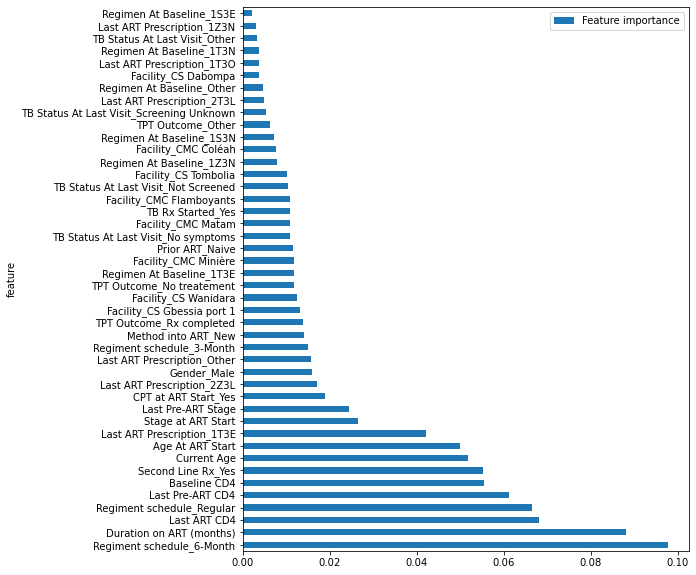

In [15]:
rf_feature_imp = RFR_clf.feature_importances_
# std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

rf_feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
for item in rf_feature_imp: rf_feature_importance["Feature importance"] = rf_feature_imp
rf_feature_importance = rf_feature_importance.sort_values(by = ["Feature importance"], ascending=False)

rf_feature_importance.to_excel('rf_feature_importance.xlsx', encoding='utf-8-sig', header = True)

ax = rf_feature_importance.plot.barh(x='feature', y='Feature importance', figsize=(8, 10))
plt.show()

## Gaussian Naive Bayes

In [16]:
# Create Gaussian Naive Bayes (NB) classifer object
NB_clf = GaussianNB()

# Train NB Classifer
NB_clf = NB_clf.fit(xtrain, ytrain.values.ravel())

# Save the model
joblib.dump(NB_clf, 'NBY_clf.pkl')

#Predict the response for test dataset
target_expected = ytest
target_predicted = NB_clf.predict(xtest)

# Area Under the Receiver Operating Characteristic Curve (ROC AUC)  
fpr, tpr, thresholds = metrics.roc_curve(target_expected, target_predicted)

# summarize the fit of the model
print('Classification report:\n', metrics.classification_report(target_expected, 
                                                                target_predicted))
print('F1 Score: ', metrics.f1_score(target_expected, target_predicted))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(target_expected, target_predicted))
print('Confusion matrix:\n', metrics.confusion_matrix(target_expected, target_predicted))

Classification report:
               precision    recall  f1-score   support

           0       0.33      0.56      0.41       457
           1       0.94      0.85      0.89      3597

    accuracy                           0.82      4054
   macro avg       0.63      0.71      0.65      4054
weighted avg       0.87      0.82      0.84      4054

F1 Score:  0.8931642617694214
AUC:  0.70709210021237
Accuracy Score:  0.819190922545634
Confusion matrix:
 [[ 257  200]
 [ 533 3064]]


### Logistic regression model implementation and evaluation

In [17]:
# Create Logistic regression classifer object
LOG_clf = LogisticRegression(random_state = 5, n_jobs = -1, max_iter = 100)

# Train Logistic regresion Classifer
LOG_clf = LOG_clf.fit(xtrain, ytrain.values.ravel())

# Save the model
joblib.dump(LOG_clf, 'LGR_clf.pkl')

#Predict the response for test dataset
target_expected = ytest
target_predicted = LOG_clf.predict(xtest)

# Area Under the Receiver Operating Characteristic Curve (ROC AUC)  
fpr, tpr, thresholds = metrics.roc_curve(target_expected, target_predicted)

# summarize the fit of the model
print('Classification report:\n', metrics.classification_report(target_expected, 
                                                                target_predicted))
print('F1 Score: ', metrics.f1_score(target_expected, target_predicted))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(target_expected, target_predicted))
print('Confusion matrix:\n', metrics.confusion_matrix(target_expected, target_predicted))

Classification report:
               precision    recall  f1-score   support

           0       0.28      0.78      0.41       457
           1       0.96      0.74      0.84      3597

    accuracy                           0.75      4054
   macro avg       0.62      0.76      0.63      4054
weighted avg       0.89      0.75      0.79      4054

F1 Score:  0.8393782383419689
AUC:  0.7632445345592516
Accuracy Score:  0.7476566354218056
Confusion matrix:
 [[ 358   99]
 [ 924 2673]]


In [18]:
logit_model=sm.Logit(ytrain,xtrain)
result=logit_model.fit()
print(result.summary2())

         Current function value: 0.484562
         Iterations: 35
                                             Results: Logit
Model:                            Logit                         Pseudo R-squared:             0.301     
Dependent Variable:               VL Suppressed_Yes             AIC:                          16352.4847
Date:                             2022-01-12 18:59              BIC:                          16653.9046
No. Observations:                 16793                         Log-Likelihood:               -8137.2   
Df Model:                         38                            LL-Null:                      -11640.   
Df Residuals:                     16754                         LLR p-value:                  0.0000    
Converged:                        0.0000                        Scale:                        1.0000    
No. Iterations:                   35.0000                                                               
----------------------------------

C:\Users\MSFuser\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Logistic regression model summary

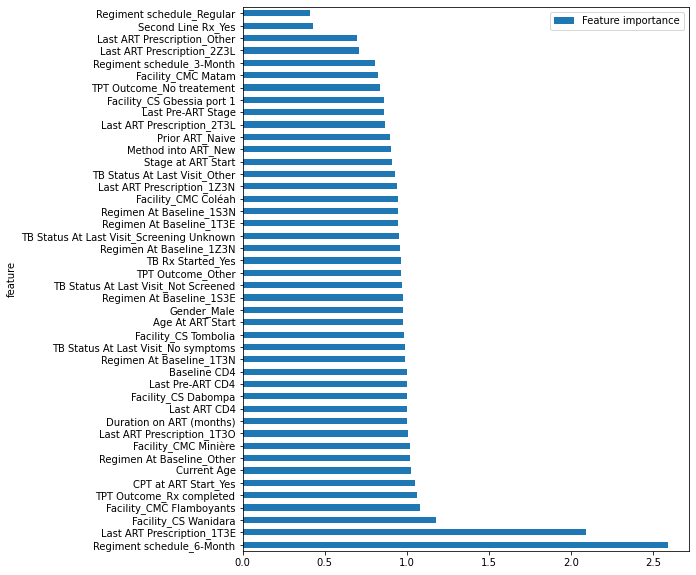

In [19]:
# Logistic regression coeficients 
logreg_coef = LOG_clf.coef_

logreg_feature_importance = pd.DataFrame(feature_names, columns = ["feature"])
for item in logreg_coef: logreg_feature_importance["Feature importance"] = pow(math.e, item)
# for item in logreg_coef: logreg_feature_importance["Feature importance"] = item
logreg_feature_importance = logreg_feature_importance.sort_values(by = ["Feature importance"], ascending=False)

logreg_feature_importance.to_excel('logreg_feature_importance.xlsx', encoding='utf-8-sig', header = True)
 
# from sklearn.linear_model import LogisticRegression
ax = logreg_feature_importance.plot.barh(x='feature', y='Feature importance', figsize=(8, 10))
plt.show()

### ROC Curves

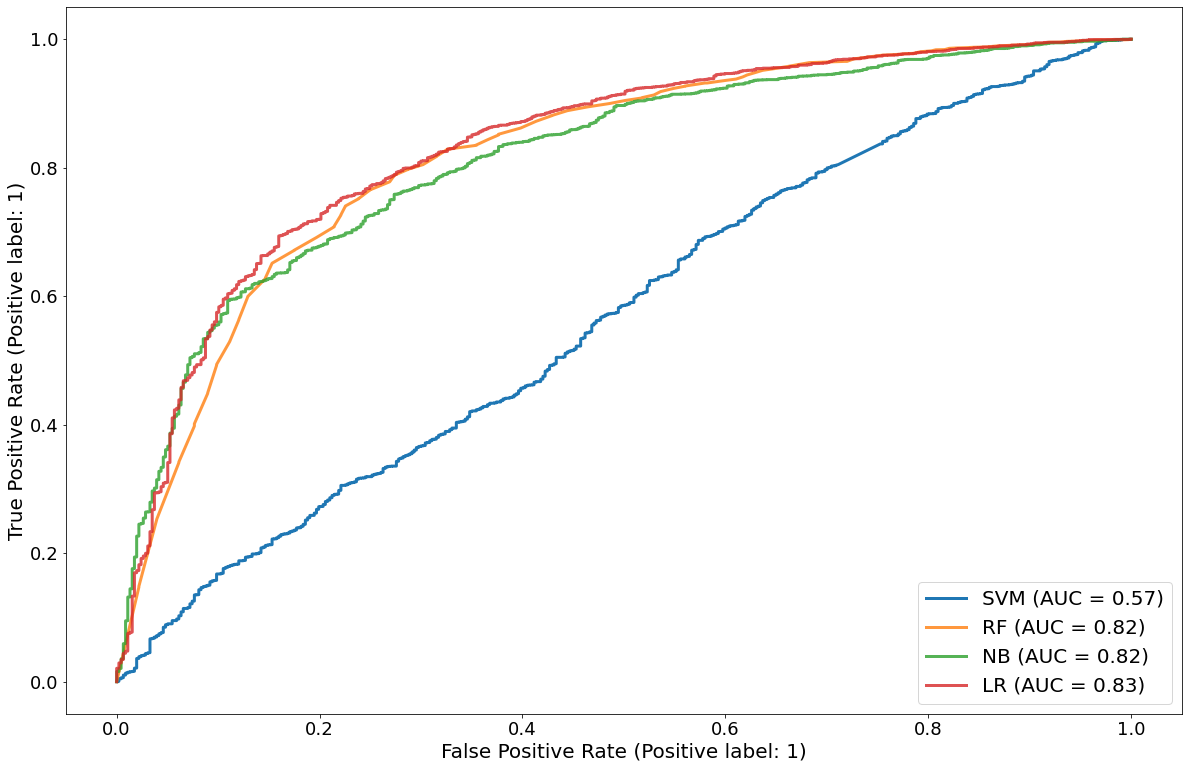

In [28]:
# SVM
SVM_clf = svm.SVC(C = 40, gamma = 'auto')
SVM_clf.fit(xtrain, ytrain.values.ravel())
ypred1 = SVM_clf.decision_function(xtest)
svc_disp = RocCurveDisplay.from_predictions(ytest, ypred1, name="SVM")

# RandomForestClassifier
RFR_clf = RandomForestClassifier(max_depth = 40)
RFR_clf = RFR_clf.fit(xtrain, ytrain.values.ravel())
ypred2 = RFR_clf.predict_proba(xtest)

ax = plt.gca()
rfc_disp = RocCurveDisplay.from_predictions(ytest, ypred2[:,1], ax=ax, name="RF", alpha=0.8)

# Naive Bayes 
NB_clf = GaussianNB()
NB_clf = NB_clf.fit(xtrain, ytrain.values.ravel())
ypred3 = NB_clf.predict_proba(xtest)

ax = plt.gca()
nyb_disp = RocCurveDisplay.from_predictions(ytest, ypred3[:,1], ax=ax, name="NB", alpha=0.8)

# Logistic regression classifer object
LOG_clf= LogisticRegression(random_state = 5, n_jobs = -1, max_iter = 100)
LOG_clf = LOG_clf.fit(xtrain, ytrain.values.ravel())
ypred4 = LOG_clf.decision_function(xtest)

plt.rcParams['figure.figsize'] = [20, 13]
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 20

ax = plt.gca()
lrg_disp = RocCurveDisplay.from_predictions(ytest, ypred4, ax=ax, name="LR", alpha=0.8)

### Stacking classifiers

['STK_clf5.pkl']

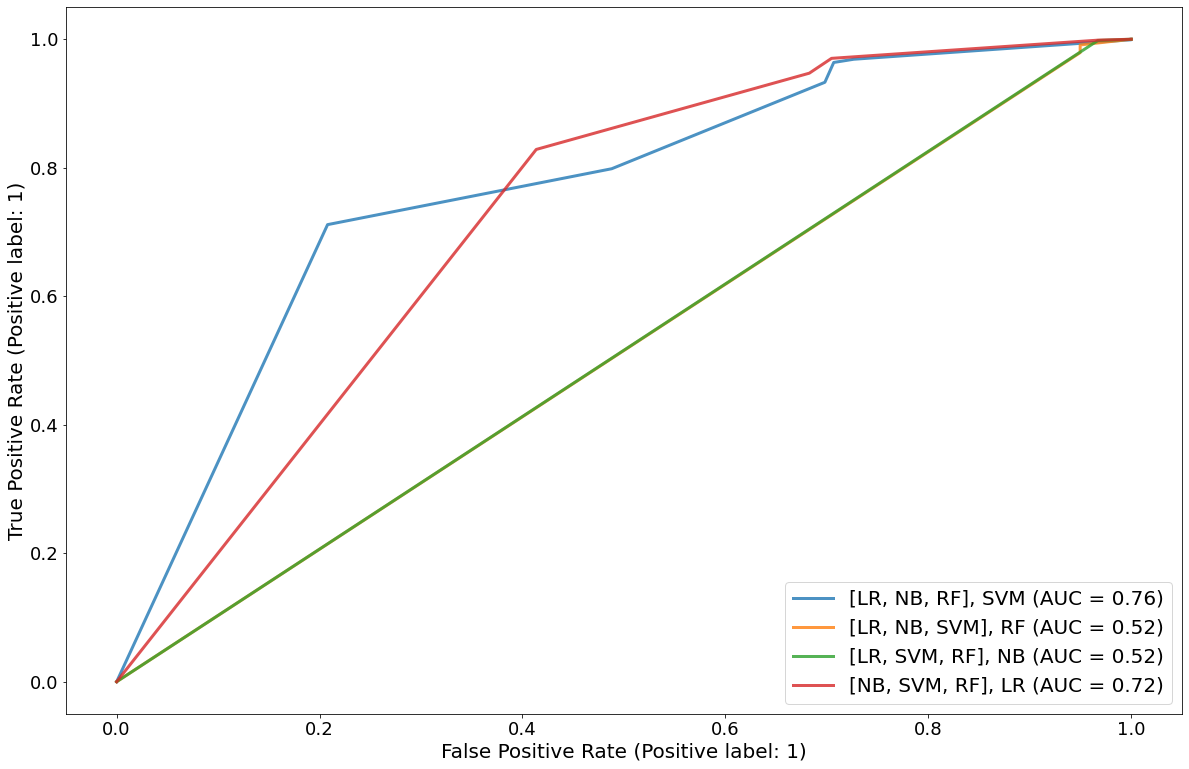

In [29]:
#Stacked classifier 
LOG_clf= LogisticRegression(random_state = 5, n_jobs = -1, max_iter = 100)
SVM_clf = svm.SVC(C = 40, gamma = 'auto')
RFR_clf = RandomForestClassifier(max_depth = 40)
NBY_clf = GaussianNB()

# [LOG_clf, NBY_clf, RFR_clf], SVM_clf Stacked classifier 
STK_clf1 = StackingClassifier(classifiers = [LOG_clf, NBY_clf, RFR_clf], 
                              meta_classifier = SVM_clf)
STK_clf1 = STK_clf1.fit(xtrain, ytrain.values.ravel())
ypred1 = STK_clf1.decision_function(xtest)

plt.rcParams['figure.figsize'] = [20, 13]
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['lines.markersize'] = 20
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['legend.fontsize'] = 20

ax = plt.gca()
stk_disp1 = RocCurveDisplay.from_predictions(ytest, ypred1, ax=ax, alpha=0.8,
                                             name="[LR, NB, RF], SVM")

# [LOG_clf, NBY_clf, SVM_clf], RFR_clf Stacked classifier 
STK_clf2 = StackingClassifier(classifiers = [LOG_clf, NBY_clf, SVM_clf], 
                              meta_classifier = RFR_clf)
STK_clf2 = STK_clf2.fit(xtrain, ytrain.values.ravel())
ypred2 = STK_clf2.predict_proba(xtest)

ax = plt.gca()
stk_disp2 = RocCurveDisplay.from_predictions(ytest, ypred2[:,1], ax=ax, alpha=0.8,
                                           name="[LR, NB, SVM], RF")

# [LOG_clf, SVM_clf, RFR_clf], NBY_clf Stacked classifier 
STK_clf3 = StackingClassifier(classifiers = [LOG_clf, SVM_clf, RFR_clf], 
                              meta_classifier = NBY_clf)
STK_clf3 = STK_clf3.fit(xtrain, ytrain.values.ravel())
ypred3 = STK_clf3.predict_proba(xtest)

ax = plt.gca()
stk_disp3 = RocCurveDisplay.from_predictions(ytest, ypred3[:,1], ax=ax, alpha=0.8,
                                           name="[LR, SVM, RF], NB")

# [NBY_clf, SVM_clf, RFR_clf], LOG_clf Stacked classifier 
STK_clf4 = StackingClassifier(classifiers = [NBY_clf, SVM_clf, RFR_clf], 
                              meta_classifier = LOG_clf)
STK_clf4 = STK_clf4.fit(xtrain, ytrain.values.ravel())
ypred4 = STK_clf4.predict_proba(xtest)

ax = plt.gca()
stk_disp4 = RocCurveDisplay.from_predictions(ytest, ypred4[:,1], ax=ax, alpha=0.8,
                                           name="[NB, SVM, RF], LR")

# [SVM_clf], LOG_clf Stacked classifier 
# STK_clf5 = StackingClassifier(classifiers = [SVM_clf], meta_classifier = LOG_clf)
# STK_clf5 = STK_clf5.fit(xtrain, ytrain.values.ravel())
# ypred5 = STK_clf5.predict_proba(xtest)

# ax = plt.gca()
# stk_disp5 = RocCurveDisplay.from_predictions(ytest, ypred5[:,1], ax=ax, alpha=0.8, name="[SVM], LR")

# Save the stacked models
joblib.dump(STK_clf1, 'STK_clf1.pkl')
joblib.dump(STK_clf2, 'STK_clf2.pkl')
joblib.dump(STK_clf3, 'STK_clf3.pkl')
joblib.dump(STK_clf4, 'STK_clf4.pkl')
joblib.dump(STK_clf5, 'STK_clf5.pkl')

In [22]:
# Summarize the fit of the model "[LR, NB, RF], SVM"

# Predict target 
ypred1 = STK_clf1.predict(xtest)
# True and false positive rate  
fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred1)

print('Classification reports [LR, NB, RF], SVM')
print('Classification report:\n', metrics.classification_report(ytest, ypred1))
print('F1 Score: ', metrics.f1_score(ytest, ypred1))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred1))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred1))

Classification reports [LR, NB, RF], SVM
Classification report:
               precision    recall  f1-score   support

           0       0.51      0.29      0.37       457
           1       0.91      0.96      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.71      0.63      0.66      4054
weighted avg       0.87      0.89      0.88      4054

F1 Score:  0.9391069012178621
AUC:  0.6289547148760607
Accuracy Score:  0.8889985199802664
Confusion matrix:
 [[ 134  323]
 [ 127 3470]]


In [23]:
# Summarize the fit of the model "[LR, NB, SVM], RF"

# Predict target 
ypred2 = STK_clf2.predict(xtest)
# True and false positive rate  
fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred2)

print('Classification reports [LR, NB, SVM], RF')
print('Classification report:\n', metrics.classification_report(ytest, ypred2))
print('F1 Score: ', metrics.f1_score(ytest, ypred2))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred2))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred2))

Classification reports [LR, NB, SVM], RF
Classification report:
               precision    recall  f1-score   support

           0       0.23      0.05      0.08       457
           1       0.89      0.98      0.93      3597

    accuracy                           0.87      4054
   macro avg       0.56      0.51      0.51      4054
weighted avg       0.82      0.87      0.84      4054

F1 Score:  0.9326095591155832
AUC:  0.5147387593235062
Accuracy Score:  0.8744449925999014
Confusion matrix:
 [[  23  434]
 [  75 3522]]


In [24]:
# Summarize the fit of the model "LR, SVM, RF], NB"

# Predict target 
ypred3 = STK_clf3.predict(xtest)
# True and false positive rate  
fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred3)

print('Classification reports [LR, SVM, RF], NB')
print('Classification report:\n', metrics.classification_report(ytest, ypred3))
print('F1 Score: ', metrics.f1_score(ytest, ypred3))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred3))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred3))

Classification reports [LR, SVM, RF], NB
Classification report:
               precision    recall  f1-score   support

           0       0.70      0.04      0.07       457
           1       0.89      1.00      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.79      0.52      0.50      4054
weighted avg       0.87      0.89      0.84      4054

F1 Score:  0.9412690089145254
AUC:  0.5165324373763938
Accuracy Score:  0.8894918598914652
Confusion matrix:
 [[  16  441]
 [   7 3590]]


In [25]:
# Summarize the fit of the model "[NB, SVM, RF], LR"

# Predict target 
ypred4 = STK_clf4.predict(xtest)
# True and false positive rate  
fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred4)

print('Classification reports [NB, SVM, RF], LR')
print('Classification report:\n', metrics.classification_report(ytest, ypred4))
print('F1 Score: ', metrics.f1_score(ytest, ypred4))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred4))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred4))

Classification reports [NB, SVM, RF], LR
Classification report:
               precision    recall  f1-score   support

           0       0.54      0.29      0.38       457
           1       0.92      0.97      0.94      3597

    accuracy                           0.89      4054
   macro avg       0.73      0.63      0.66      4054
weighted avg       0.87      0.89      0.88      4054

F1 Score:  0.9408268035666036
AUC:  0.630622771589989
Accuracy Score:  0.8919585594474593
Confusion matrix:
 [[ 134  323]
 [ 115 3482]]


In [26]:
# Summarize the fit of the model "[SVM], LR"

# Predict target 
ypred5 = STK_clf5.predict(xtest)
# True and false positive rate  
fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred5)

print('Classification reports [SVM], LR')
print('Classification report:\n', metrics.classification_report(ytest, ypred5))
print('F1 Score: ', metrics.f1_score(ytest, ypred5))
print('AUC: ', metrics.auc(fpr, tpr))
print('Accuracy Score: ', metrics.accuracy_score(ytest, ypred5))
print('Confusion matrix:\n', metrics.confusion_matrix(ytest, ypred5))

Classification reports [SVM], LR
Classification report:
               precision    recall  f1-score   support

           0       0.23      0.05      0.08       457
           1       0.89      0.98      0.93      3597

    accuracy                           0.87      4054
   macro avg       0.56      0.51      0.51      4054
weighted avg       0.82      0.87      0.84      4054

F1 Score:  0.9326095591155832
AUC:  0.5147387593235062
Accuracy Score:  0.8744449925999014
Confusion matrix:
 [[  23  434]
 [  75 3522]]


In [27]:
print('Detailed description of LR algorithm')
print(LOG_clf)
print('Detailed description of SVM algorithm')
print(SVM_clf)
print('Detailed description of RF algorithm')
print(RFR_clf)
print('Detailed description of NB algorithm')
print(NBY_clf)
print('Detailed description of Stacked classifier 1')
print(STK_clf1)
print('Detailed description of Stacked classifier 2')
print(STK_clf2)
print('Detailed description of Stacked classifier 3')
print(STK_clf3)
print('Detailed description of Stacked classifier 4')
print(STK_clf4)
print('Detailed description of Stacked classifier 5')
print(STK_clf5)

Detailed description of LR algorithm
LogisticRegression(n_jobs=-1, random_state=5)
Detailed description of SVM algorithm
SVC(C=40, gamma='auto')
Detailed description of RF algorithm
RandomForestClassifier(max_depth=40)
Detailed description of NB algorithm
GaussianNB()
Detailed description of Stacked classifier 1
StackingClassifier(classifiers=[LogisticRegression(n_jobs=-1, random_state=5),
                                GaussianNB(),
                                RandomForestClassifier(max_depth=40)],
                   meta_classifier=SVC(C=40, gamma='auto'))
Detailed description of Stacked classifier 2
StackingClassifier(classifiers=[LogisticRegression(n_jobs=-1, random_state=5),
                                GaussianNB(), SVC(C=40, gamma='auto')],
                   meta_classifier=RandomForestClassifier(max_depth=40))
Detailed description of Stacked classifier 3
StackingClassifier(classifiers=[LogisticRegression(n_jobs=-1, random_state=5),
                                SVC(C

## Comment on model evaluations

The end !